<center><b>Least Squares Fitting using SciPy curve_fit</b></center>

Taking <a href="https://web.archive.org/web/20060309210852/http://www.einstein-online.info/en/spotlights/binding_energy/binding_energy/index.txt">data</a> of binding energies of nucleii, a model fit of the Semi-Empirical Mass formula can be made.

Semi-Empirical Mass Formula:
<center>$B = a_vA-a_sA^{2/3}-a_c\frac{Z(Z-1)}{A^{1/3}}-a_a\frac{(N-Z)^2}{A}+\delta(A)$</center>

Reading data from the file using numpy loadtxt, only the 1st, 2nd and 5th columns are of interest.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, fixed

%matplotlib notebook

with open('data.dat') as f:
    lines = (line for line in f if not line.startswith('#'))
    read_data = np.loadtxt(lines, delimiter = ' ', usecols=(0, 1, 5), unpack = True)

The curve_fit function has the following usage. If we have a model function, $f$, we assume the data, $y$, is simply $y = f(x) +$ errors then a curve fit can be performed in the following way:

1. Define the model function which takes $x$ and some free parameters and returns the model solution

2. Call the curve_fit function, passing it the model function, the x data, the y data and optionally a list of initial values for the fitting parameters

3. curve_fit will return 2 tuples: the first contains the least squared fit model parameters and the second contains the covariance matrix

4. Finally the model function can be called individually, passing it the fitted parameters, in order to obtain the fitted model

In [2]:
from scipy.optimize import curve_fit

def model_fit(data,term_mask,exclude):
    A = data[0][exclude:]
    Z = data[1][exclude:]
    B = data[2][exclude:]

    def _semi_empirical_mass(X, a_v, a_s, a_c, a_a, a_p):
        model = np.zeros_like(X)
        if term_mask[0]:
            vol = a_v
            model += vol
        if term_mask[1]:
            sa = -a_s*X**(-1./3.)
            model += sa
        if term_mask[2]:
            es = -a_c*Z*(Z-1)*X**(-4./3.)
            model += es
        if term_mask[3]:
            asy = -a_a*((X-2*Z)**2)*X**(-2)
            model += asy
        if term_mask[4]:
            N = X-Z
            parity = np.zeros_like(X)
            for i in range(len(parity)):
                if N[i] % 2 == 0 and Z[i] % 2 == 0:
                    parity[i] = a_p*X[i]**(-3./4.)
                elif N[i] % 2 == 1 and Z[i] % 2 == 1:
                    parity[i] = -a_p*X[i]**(-3./4.)
                else:
                    parity[i] = 0.0
            model += parity/X
        
        return model

    p0 = [15.8,18.0,0.72,23.5,33.5]
    popt, pcov = curve_fit(_semi_empirical_mass, A, B, p0 = p0)
    
    model = _semi_empirical_mass(A, popt[0], popt[1], popt[2], popt[3], popt[4])
    ax.set_title((str(popt)))
    line.set_data(A,model)
    display(fig)

def widget_update(b_v = True,b_s = True,b_c = True,b_a = True,b_p = True, exclude=0):
    term_mask = [b_v,b_s,b_c,b_a,b_p]
    model_fit(read_data,term_mask,exclude)

Below is an interactive plot for the binding energy data and the fitted SEMF model. The fitted parameters are shown in the figure title and individual terms in the SEMF can be turned off to see their effect.

In [3]:
fig = plt.figure(figsize = (12,6))
ax = plt.subplot(111)

ax.set_xlabel('Atomic Number / A')
ax.set_ylabel('Binding Energy per Nucleon (MeV) / (B/A)')

ax.plot(read_data[0],read_data[2],'bx')
ax.set_xlim([0,max(read_data[0])])

line, = ax.plot([],[],'r-')

interact(widget_update, b_v = widgets.Checkbox(description='Volume Term',value=True),
                        b_s = widgets.Checkbox(description='Surface Area Term',value=False),
                        b_c = widgets.Checkbox(description='Coulomb Term',value=False),
                        b_a = widgets.Checkbox(description='Asymmetry Term',value=False),
                        b_p = widgets.Checkbox(description='Parity Term',value=False),
                        exclude = widgets.IntSlider(description='Exclude first n points',
                        min=0,max=50))

<IPython.core.display.Javascript object>

From Part II Particle and Nuclear Physics (in MeV):

<center>$a_v = 15.8$, $a_s = 18.0$, $a_c = 0.72$, $a_a = 23.5$, $a_p = 33.5$</center>


<IPython.core.display.Javascript object>


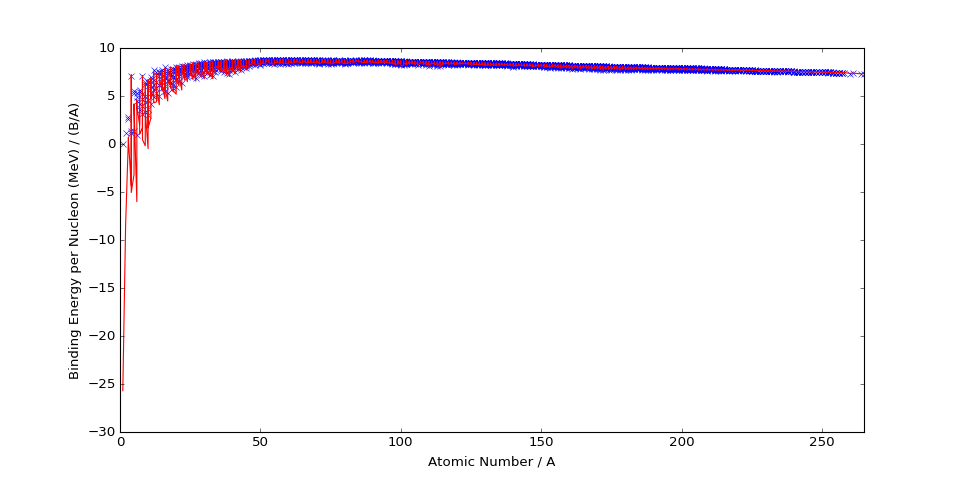

In [4]:
def semf(X, Y, a_v, a_s, a_c, a_a, a_p):
    model = np.zeros_like(X)
    vol = a_v
    sa = -a_s*X**(-1./3.)
    es = -a_c*Y*(Y-1)*X**(-4./3.)
    asy = -a_a*((X-2*Y)**2)*X**(-2)
    
    N = X-Y
    parity = np.zeros_like(X)
    for i in range(len(parity)):
        if N[i] % 2 == 0 and Y[i] % 2 == 0:
            parity[i] = a_p*X[i]**(-3./4.)
        elif N[i] % 2 == 1 and Y[i] % 2 == 1:
            parity[i] = -a_p*X[i]**(-3./4.)
        else:
            parity[i] = 0.0

    model = vol+sa+es+asy+parity/X
    return model

fig2 = plt.figure(figsize = (12,6))
ax2 = plt.subplot(111)

ax2.set_xlabel('Atomic Number / A')
ax2.set_ylabel('Binding Energy per Nucleon (MeV) / (B/A)')

ax2.plot(read_data[0],read_data[2],'bx')
ax2.set_xlim([0,max(read_data[0])])

p0 = [15.8,18.0,0.72,23.5,33.5]
model_ln = semf(read_data[0], read_data[1], p0[0], p0[1], p0[2], p0[3], p0[4])

ax2.plot(read_data[0],model_ln,'r-')